In [13]:
import numpy as np
from scipy import signal
import soundfile as sf

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_number_of_blocks(num_samples, blocksize, hopsize):
    """
    Return start and end indices of sample buffers
    Args:
        num_samples (int): Total number of samples
        blocksize (int): Blocksize in samples
        hopsize (int): Hopsize in samples
    Returns:
        num_blocks (int): Number of blocks (without zero-padding)
    """
    return int(np.fix((num_samples - (blocksize - hopsize)) / hopsize))

def buffer_indices(num_samples, blocksize, hopsize):
    """ 
    Return start and end indices of sample buffers
    Args:
        num_samples (int): Total number of samples
        blocksize (int): Blocksize in samples
        hopsize (int): Hopsize in samples
    Returns:
        buffer_idx (2d np.ndarray): Sample indices aranged as 2d array,
                                    Columns are buffer blocks (blocksize x n_blocks)
    """
    num_frames = get_number_of_blocks(num_samples, blocksize, hopsize)

    buffer_idx = np.tile(np.arange(blocksize)[:, np.newaxis], (1, num_frames)) + \
                 np.tile(np.arange(num_frames)*hopsize, (blocksize, 1))
    return buffer_idx

def buffer_signal(x, blocksize, hopsize):
    num_samples = len(x)
    buffer_idx = buffer_indices(num_samples, blocksize, hopsize)
    return x[buffer_idx]


In [3]:
class VehicleDirectionFeatureExtractor:
    """ Class implements feature extraction for CNN-based detection of vehicle moving direction.
        A block-wise cross-correlation is computed and stacked over time. Then, only the center part around the
        zero-lag is kept, since we only focus on very small time-shifts here (between the left and right audio channel).
    """

    def __init__(self,
                 blocksize_sec=1,
                 hopsize_sec=.05,
                 center_one_side_margin = 25):
        """ Initialize class
        Args:
            blocksize_sec (float): Blocksize in seconds
            hopsize_sec (float): Hopsize in seconds
            center_one_side_margin (int): One-sided margin around zero-lag in cross-correlation matrix, which will be
                                          used to extract center part as cc_matrix representation
        """
        self.blocksize_sec = blocksize_sec
        self.hopsize_sec = hopsize_sec
        self.center_one_side_margin = center_one_side_margin

    def compute_spectrogram(self,
                            fn_wav,
                            normalize=True):
        """ Compute feature representation for stereo input (cross-correlation matrix)
        Args:
            fn_wav (string): WAV file
            normalize (bool): Switch to center columns in cross-correlation matrix to zero mean
        Returns:
            correlation matrix (2D np.ndarray: Center part of cross-correlation matrix around zero-lag index
            time_axis_sec (ndarray): Time frames in seconds (num_frames)
            lag_axis_sec (ndarray): Lag values in seconds (num_bins)
        """
        # load audio
        # x, fs = AudioImport.loadWAV(fn_wav)
        x, fs = sf.read(fn_wav)
        assert x.ndim == 2

        # get left and right channel
        x_l = x[:, 0]
        x_r = x[:, 1]

        blocksize_samples = int(fs * self.blocksize_sec)
        hopsize_samples = int(fs * self.hopsize_sec)

        print('Hopsize in samples = ', hopsize_samples)

        # signal buffering
        b_l = buffer_signal(x_l, blocksize_samples, hopsize_samples).T
        b_r = buffer_signal(x_r, blocksize_samples, hopsize_samples).T

        # block-wise cross-correlation between left and right channel
        num_blocks = b_l.shape[0]
        cc_mat = np.zeros((num_blocks, 2 * blocksize_samples - 1), dtype=np.float16)
        for b in range(num_blocks):
            cc_mat[b, :] = signal.fftconvolve(b_l[b, :], b_r[b, :][::-1], mode='full')

        time_axis_sec = np.arange(num_blocks)*self.hopsize_sec

        # use central part around zero-lag index as cross-correlation matrix representation
        assert self.center_one_side_margin <= blocksize_samples - 1, "Center margin must be smaller than {}!".format(blocksize_samples)
        cc_matrix = cc_mat[:, blocksize_samples - 1 - self.center_one_side_margin : blocksize_samples - 1 + self.center_one_side_margin + 1].T

        lag_axis_sec = np.arange(- self.center_one_side_margin, self.center_one_side_margin + 1)*1/fs

        # frame-wise centering to zero mean
        if normalize:
            cc_matrix -= np.mean(cc_matrix, axis=0)
            # cc_matrix -= np.min(cc_matrix)
            # cc_matrix = np.log(cc_matrix+np.finfo(float).eps)

        return cc_matrix, time_axis_sec, lag_axis_sec

In [4]:
vdfe = VehicleDirectionFeatureExtractor()

In [44]:
# 2019-11-19-16-30_Langewiesener-Strasse_50Kmh_1697744_A_D_TR_SE_CH34.wav
cc_matrix, time_axis_sec, lag_axis_sec = vdfe.compute_spectrogram("../dataset/IDMT_Traffic/audio/2019-11-19-16-30_Langewiesener-Strasse_50Kmh_1595840_A_D_CL_ME_CH12.wav")

Hopsize in samples =  2400


In [45]:
cc_matrix

array([[ 0.219   ,  0.2158  ,  0.2161  , ..., -0.09436 , -0.10394 ,
        -0.1109  ],
       [ 0.2153  ,  0.2139  ,  0.2168  , ..., -0.0867  , -0.09784 ,
        -0.1049  ],
       [ 0.2068  ,  0.207   ,  0.2129  , ..., -0.07776 , -0.0905  ,
        -0.0976  ],
       ...,
       [ 0.01776 ,  0.012085,  0.01019 , ..., -0.08856 , -0.07825 ,
        -0.0702  ],
       [ 0.01337 ,  0.00806 ,  0.00763 , ..., -0.0991  , -0.0885  ,
        -0.0806  ],
       [ 0.00775 ,  0.002625,  0.003479, ..., -0.10925 , -0.0986  ,
        -0.09125 ]], dtype=float16)

In [46]:
time_axis_sec.shape

(21,)

In [47]:
lag_axis_sec.shape

(51,)

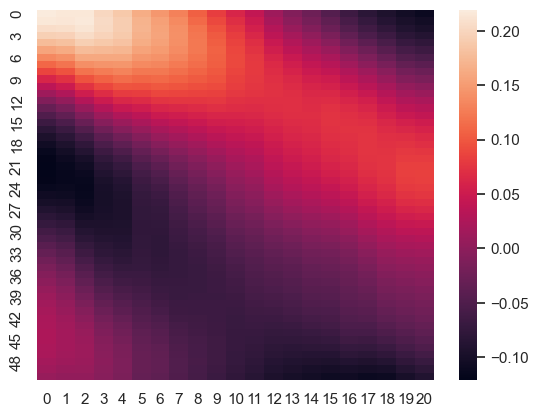

In [48]:
sns.set()
ax = sns.heatmap(cc_matrix)
plt.show()